In [37]:
import os

import scipy.io as sio
from scipy.io import readsav
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import emcee
from astropy.io import fits
from tqdm.notebook import tqdm
import scipy.stats
from scipy.stats import median_abs_deviation 
from residual_plot import residual_plot
from Least_sq_fit import Least_sq_fit
from Weighted_LS_fit import Weighted_LS_fit
from Weighted_LS_crossval_fit import Weighted_LS_crossval_fit
from multi_residual_plot import multi_residual_plot



In [58]:
star_name = '26965'#'101501'#34411# '26965', '10700'
sigma_og = int(round(7.368447606251439*2.335,0))
#10700: sigma = 7.383140920635955
#101501: sigma = 7.962301628103782
#34411: sigma = 8.067395257041321
#26965: sigma = 7.368447606251439
file_end = 'best_fit' #"best_fit"#"best_fit" #"prov_rvs"#or 

hdul_open = fits.open('HD'+star_name+'/binned_ccfs/binned_ccfs_'+file_end+'.fits', memmap=False)
wls = hdul_open[1].data['wls']
ccf_list = hdul_open[1].data['binned_ccfs']#[8:]
ccf_list = ccf_list - np.median(ccf_list, axis=0)
median_residual = np.median(ccf_list, axis=0)
std_residual = np.std(ccf_list, axis=0)
rescaled_resids = (ccf_list-median_residual)/std_residual

bjd_list = hdul_open[2].data['bjd']#[8:]

if file_end =="best_fit":
    rv_list = hdul_open[2].data['mu_og_list']
else:
    rv_list = hdul_open[2].data['vrad_star']

#rv_list = hdul_open[2].data['vrad_star']# hdul_open[2].data['mu_og_list'] # [8:] #hdul_open[2].data['mu_og_list'][8:] #
rv_error = hdul_open[2].data['svrad_star']#[8:]

# create pandas dataframe
df = pd.DataFrame(list(zip(bjd_list, rv_list, rv_error, rescaled_resids)), columns=["BJD","vrad", "svrad", "CCF"])
df_sorted = df.sort_values(by=['BJD']) 

In [59]:
# format data for LS fit
rv_np = np.array(list(df_sorted["vrad"]-np.mean(df_sorted["vrad"])))*1000
s_rv_np = np.array(list(df_sorted["svrad"]))*1000
ccf_list_np = np.array(list(df_sorted["CCF"]))
ccf_list_np_transpose = ccf_list_np.transpose()
time_np = np.array(df_sorted["BJD"])-np.min(df_sorted["BJD"])

0.0 1.0


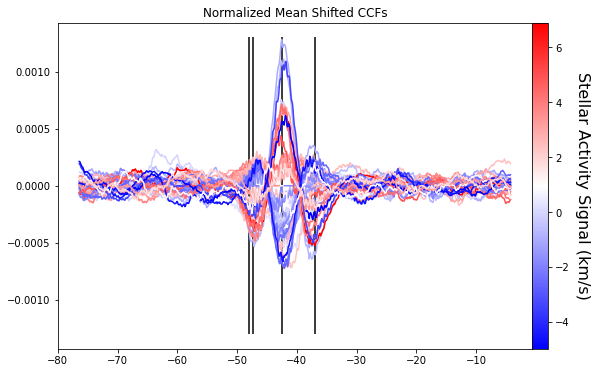

In [60]:
residual_plot(rv_np, wls[0], ccf_list_np*std_residual, "median", plot_title = "Normalized Mean Shifted CCFs")
plt.vlines(wls[0][ccf_indexes], ymin=-0.0013, ymax=0.0013, color="k")


In [55]:
ccf_indexes

[318, 335, 352, 369]

37

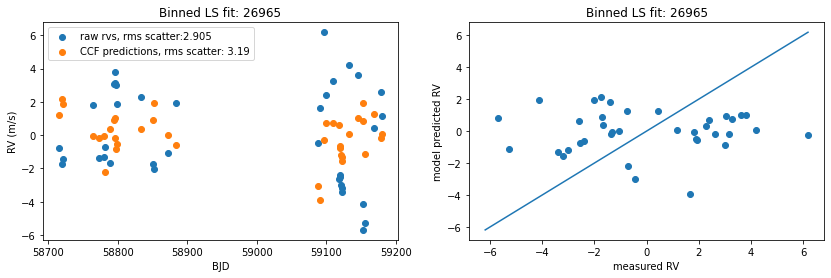

In [53]:
# perform the L-S fit on training data --------------
start_index = 301
ccf_indexes =  [start_index+sigma_og, start_index+2*sigma_og, 
                start_index+3*sigma_og, start_index+4*sigma_og] #[284, 284+sigma_og, 340, 394]
#[328, 328+sigma_og, 328+2*sigma_og, 328+3*sigma_og]#[352, 305, 325, 367, 406]
# HD 34411: [350, 388, 398, 408, 441]
# HD 10150: [330, 364, 376, 388, 398, 425]
# HD 26965: [301, 339, 349, 359, 392]
# HD 10700: [306, 347, 357, 367, 406]

# set all weights to 1
s_rv_np = [1]*len(rv_np)

y_val_preds_list, raw_val_rms, new_val_rms, new_train_rms_list, a_coeff_list = Weighted_LS_crossval_fit(ccf_indexes, ccf_list_np, rv_np, s_rv_np)
y = rv_np

#plot the results
fig, ax = plt.subplots(1,2, figsize=(14, 4))
ax[0].scatter(time_np+np.min(df_sorted["BJD"]),
              y, label="raw rvs, rms scatter:"+str(round(raw_val_rms,3)))
ax[0].scatter(time_np+np.min(df_sorted["BJD"]),
              y_val_preds_list, label="CCF predictions, rms scatter: "+str(round(new_val_rms,3)))
ax[0].set_ylabel("RV (m/s)")
ax[0].set_xlabel("BJD")
ax[0].set_title("Binned LS fit: "+star_name)
ax[0].legend()

ax[1].scatter(y, y_val_preds_list)
abs_max_y = np.max(np.abs(y))
ax[1].plot([-abs_max_y,abs_max_y],
           [-abs_max_y,abs_max_y])
ax[1].set_xlabel("measured RV")
ax[1].set_ylabel("model predicted RV")
ax[1].set_title("Binned LS fit: "+star_name)

len(rv_np)

3.343536532412202

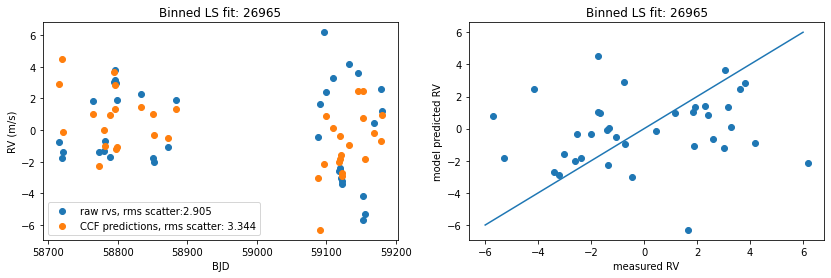

In [24]:
# Divide data into training and validation sets
#print("og list: "+str(s_rv_np))
y_val_preds_list = []

for i in range(0, len(rv_np)):
    train_rv_np = np.delete(rv_np, i)
    train_s_rv_np = np.delete(s_rv_np,i)
    train_ccf_list_np = np.delete(ccf_list_np, i, 0)
    train_ccf_list_np_transpose = train_ccf_list_np.transpose()
    train_time_np = np.delete(time_np,i)
    
    val_rv_np = rv_np[i]
    val_s_rv_np = s_rv_np[i]
    val_ccf_list_np = ccf_list_np[i]
    val_ccf_list_np_transpose = np.array([val_ccf_list_np]).transpose()
    train_time_np = time_np[i]
    
    #double checks if the validation example is excluded from the training set
    if val_rv_np in train_rv_np:
        print("val rv example is in training set!")
    if val_s_rv_np in train_s_rv_np:
        print("val s_rv example is in training set!")
    if any(x in val_ccf_list_np.tolist() for x in [list(ccf_list_np[i])]):
        print("val ccf example is in training set!")
        
    # perform the L-S fit on training data --------------
    ccf_indexes =  [352, 305, 325, 367, 406]
    # HD 34411: [350, 388, 398, 408, 441]
    # HD 10150: [330, 364, 376, 388, 398, 425]
    # HD 26965: [301, 339, 349, 359, 392]
    # HD 10700: [306, 347, 357, 367, 406]
    a_coeff, y_train_preds, CCF_train_matrix, raw_train_rms, new_train_rms = Weighted_LS_fit(ccf_indexes, train_ccf_list_np, 
                                                     train_ccf_list_np_transpose,train_rv_np, train_s_rv_np)
    n_rows = len([val_ccf_list_np])
    CCF_val_matrix = np.zeros((n_rows, len(ccf_indexes)))
    for j in np.arange(0, len(ccf_indexes)):
        CCF_val_matrix[:, j] = val_ccf_list_np_transpose[ccf_indexes[j]]  # (for all observations)

    y_val_preds = (CCF_val_matrix.dot(a_coeff[1:]) + a_coeff[0]).tolist()[0]
    y_val_preds_list.append(y_val_preds)
    
y = rv_np
# Compute the scatter metric
raw_val_rms = np.std(y, ddof=1)
new_val_rms = np.std(y - y_val_preds_list, ddof=1)
    
#plot the results
fig, ax = plt.subplots(1,2, figsize=(14, 4))
ax[0].scatter(time_np+np.min(df_sorted["BJD"]),
              y, label="raw rvs, rms scatter:"+str(round(raw_val_rms,3)))
ax[0].scatter(time_np+np.min(df_sorted["BJD"]),
              y_val_preds_list, label="CCF predictions, rms scatter: "+str(round(new_val_rms,3)))
ax[0].set_ylabel("RV (m/s)")
ax[0].set_xlabel("BJD")
ax[0].set_title("Binned LS fit: "+star_name)
ax[0].legend()

ax[1].scatter(y, y_val_preds_list)
ax[1].plot([-6,6],[-6,6])
ax[1].set_xlabel("measured RV")
ax[1].set_ylabel("model predicted RV")
ax[1].set_title("Binned LS fit: "+star_name)


np.std(y-y_val_preds_list,ddof=1)

Text(0, 0.5, 'RV (m/s)')

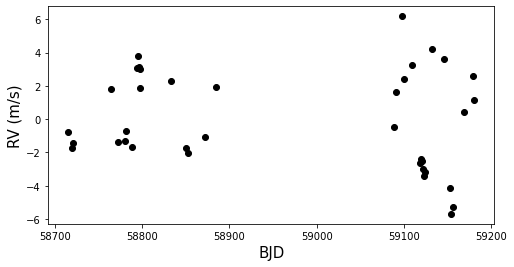

In [25]:
fig, ax = plt.subplots(1,1, figsize=(8, 4))

x = df_sorted["BJD"]
y = rv_np
yerr = df_sorted["svrad"]

#ax[0].scatter(txt_file["BJD_UTC"]-2400000, txt_file["vrad"]-np.mean(txt_file["vrad"]))
ax.errorbar(x, y, yerr = yerr, fmt = 'o', color='k')
ax.set_xlabel("BJD", size=15)
ax.set_ylabel("RV (m/s)",size=15)


In [17]:
# Genetic Algorithm to find the optimal ccf params with cross_validation 
# where the performance is evaluated based on the training rms 

possible_indexes = np.arange(295, 460)#410)#np.arange(0, len(ccf_list_np[0])-1)
ccf_indexes = [301, 339, 349, 359, 392]#, 368, 401, 500, 600]
best_indexes =[301, 339, 349, 359, 392]#, 368, 401, 500, 600]
best_rms = np.std(y, ddof=1) #m/s

print(str(round(best_rms,3))+", og indexes: "+str(best_indexes))

#jumps = 0
#while jumps <100000:
for jumps in tqdm(range(10000)):
    # Choose the random index to replace in the ccf
    rand_index = np.random.randint(0, len(ccf_indexes))
    a = ccf_indexes[0:rand_index]
    b = ccf_indexes[rand_index+1:]
    remainder_indexes = np.concatenate((a, b))
    
    # Choose what index to replace it with
    new_ccf_loc = np.random.choice(possible_indexes)
    
    # check whether this index already exists in the array. If it does, it assigns a new one until it does not exist in the array anymore
    while new_ccf_loc in ccf_indexes or any(x in (np.abs(np.array(remainder_indexes)-new_ccf_loc)) for x in [0,1,2, 3,4]):
        new_ccf_loc = np.random.choice(possible_indexes)
    
    #while 2 in np.abs(np.array(ccf_indexes)-new_ccf_loc):
    #    new_ccf_loc = np.random.choice(possible_indexes)
    
    #print(str(rand_index)+", "+str(new_ccf_loc))
    
    # replace it
    ccf_indexes[rand_index] = new_ccf_loc
    
    # perform the L-S fit --------------
    y_preds, raw_val_rms, new_val_rms, new_train_rms_list, a_coeff_list = Weighted_LS_crossval_fit(ccf_indexes, ccf_list_np, rv_np, s_rv_np)
    y = rv_np
    
    new_rms = np.std(y_preds-y)#np.mean(new_train_rms_list)
    
    # Evaluate the L-S fit --------------
    jumps +=1
    # check whether the new rms is lower than the previously best rms
    if new_rms < best_rms:
        best_indexes[rand_index] = new_ccf_loc
        best_rms = new_rms
        ccf_indexes = best_indexes.copy()
        #print(", best indexes: "+str(best_indexes))
        print("jump: "+str(jumps)+", corrected rms: "+str(round(new_rms,3))+", best indexes: "+str(best_indexes))#+", a_coeff: "+str(a_coeff))
    else: #rms is not lower
        # resets the ccf_indexes back to the previously best ones
        ccf_indexes = best_indexes.copy()
        #print("WORSE: "+str(round(new_rms,3))+", ccf indexes: "+str(ccf_indexes))
        #print(", best indexes: "+str(best_indexes))
        #continue

print(str(round(best_rms,3))+", best indexes: "+str(best_indexes))

2.905, og indexes: [301, 339, 349, 359, 392]


jump: 1, corrected rms: 2.825, best indexes: [301, 339, 349, 359, 369]
jump: 12, corrected rms: 2.593, best indexes: [301, 339, 349, 359, 397]
jump: 39, corrected rms: 2.57, best indexes: [301, 425, 349, 359, 397]
jump: 45, corrected rms: 2.555, best indexes: [301, 425, 349, 359, 378]
jump: 89, corrected rms: 2.419, best indexes: [301, 425, 348, 359, 378]
jump: 431, corrected rms: 2.402, best indexes: [301, 425, 347, 359, 378]
jump: 450, corrected rms: 2.402, best indexes: [301, 426, 347, 359, 378]
jump: 479, corrected rms: 2.289, best indexes: [301, 420, 347, 359, 378]

2.289, best indexes: [301, 420, 347, 359, 378]


In [10]:
# Genetic Algorithm to find the optimal ccf params with cross_validation 
# where the performance is evaluated based on the training rms 

possible_indexes = np.arange(295, 410)#np.arange(0, len(ccf_list_np[0])-1)
ccf_indexes = [306, 347, 357, 367, 406]#, 368, 401, 500, 600]
best_indexes =[306, 347, 357, 367, 406]#, 368, 401, 500, 600]
best_rms = np.std(y, ddof=1) #m/s

print(str(round(best_rms,3))+", og indexes: "+str(best_indexes))

y_val_preds_list = []
a_coeff_list = []
new_train_rms_list = []
best_indexes_list = []

for i in tqdm(range(len(rv_np))):#range(0, len(rv_np)):
    print("-------------------")
    print("val slice: "+str(i))
    train_rv_np = np.delete(rv_np, i)
    train_s_rv_np = np.delete(s_rv_np, i)
    train_ccf_list_np = np.delete(ccf_list_np, i, 0)
    train_ccf_list_np_transpose = train_ccf_list_np.transpose()
    #train_time_np = np.delete(time_np, i)

    val_rv_np = rv_np[i]
    val_s_rv_np = s_rv_np[i]
    val_ccf_list_np = ccf_list_np[i]
    val_ccf_list_np_transpose = np.array([val_ccf_list_np]).transpose()
    #train_time_np = time_np[i]
    
    
    ccf_indexes = [306, 347, 357, 367, 406]#, 368, 401, 500, 600]
    best_indexes =[306, 347, 357, 367, 406]#, 368, 401, 500, 600]
    best_rms = np.std(y, ddof=1)
    #for jumps in tqdm(range(3000)):
    jumps = 0
    while jumps <3000:
        # Choose the random index to replace in the ccf
        rand_index = np.random.randint(0, len(ccf_indexes))
        a = ccf_indexes[0:rand_index]
        b = ccf_indexes[rand_index+1:]
        remainder_indexes = np.concatenate((a, b))

        # Choose what index to replace it with
        new_ccf_loc = np.random.choice(possible_indexes)

        # check whether this index already exists in the array. If it does, it assigns a new one until it does not exist in the array anymore
        while new_ccf_loc in ccf_indexes or any(x in (np.abs(np.array(remainder_indexes)-new_ccf_loc)) for x in [0,1,2, 3]):
            new_ccf_loc = np.random.choice(possible_indexes)

        #while 2 in np.abs(np.array(ccf_indexes)-new_ccf_loc):
        #    new_ccf_loc = np.random.choice(possible_indexes)

        #print(str(rand_index)+", "+str(new_ccf_loc))

        # replace it
        ccf_indexes[rand_index] = new_ccf_loc

        # perform the L-S fit --------------
        a_coeff, y_preds, CCF_matrix, og_rms, new_rms = Weighted_LS_fit(ccf_indexes,
                                                                        train_ccf_list_np,
                                                                        train_ccf_list_np_transpose,
                                                                        train_rv_np,
                                                                        train_s_rv_np)
        y = rv_np

        # Evaluate the L-S fit --------------
        jumps +=1
        # check whether the new rms is lower than the previously best rms
        if new_rms < best_rms:
            best_indexes[rand_index] = new_ccf_loc
            best_rms = new_rms
            ccf_indexes = best_indexes.copy()
            #print(", best indexes: "+str(best_indexes))
            print("jump: "+str(jumps)+", corrected rms: "+str(round(new_rms,3))+", best indexes: "+str(best_indexes))#+", a_coeff: "+str(a_coeff))
        else: #rms is not lower
            # resets the ccf_indexes back to the previously best ones
            ccf_indexes = best_indexes.copy()
            #print("WORSE: "+str(round(new_rms,3))+", ccf indexes: "+str(ccf_indexes))
            #print(", best indexes: "+str(best_indexes))
            #continue
    best_indexes_list.append(best_indexes)
    
    a_coeff_list.append(a_coeff)
    new_train_rms_list.append(new_rms)
    n_rows = len([val_ccf_list_np])
    CCF_val_matrix = np.zeros((n_rows, len(ccf_indexes)))
    for j in np.arange(0, len(ccf_indexes)):
        CCF_val_matrix[:, j] = val_ccf_list_np_transpose[ccf_indexes[j]]  # (for all observations)

    y_val_preds = (CCF_val_matrix.dot(a_coeff[1:]) + a_coeff[0]).tolist()[0]
    y_val_preds_list.append(y_val_preds)

print(str(round(best_rms,3))+", best indexes: "+str(best_indexes))

1.047, og indexes: [306, 347, 357, 367, 406]


-------------------
val slice: 0
jump: 1, corrected rms: 0.62, best indexes: [306, 347, 337, 367, 406]
jump: 4, corrected rms: 0.619, best indexes: [306, 295, 337, 367, 406]
jump: 14, corrected rms: 0.618, best indexes: [306, 295, 337, 333, 406]
jump: 15, corrected rms: 0.617, best indexes: [306, 295, 337, 397, 406]
jump: 16, corrected rms: 0.586, best indexes: [306, 295, 337, 350, 406]
jump: 18, corrected rms: 0.585, best indexes: [306, 361, 337, 350, 406]
jump: 31, corrected rms: 0.561, best indexes: [306, 361, 343, 350, 406]
jump: 46, corrected rms: 0.542, best indexes: [306, 394, 343, 350, 406]
jump: 124, corrected rms: 0.517, best indexes: [312, 394, 343, 350, 406]
jump: 219, corrected rms: 0.497, best indexes: [312, 338, 343, 350, 406]
jump: 393, corrected rms: 0.497, best indexes: [312, 335, 343, 350, 406]
jump: 645, corrected rms: 0.494, best indexes: [312, 334, 343, 350, 406]
jump: 901, corrected rms: 0.486, best indexes: [312, 388, 343, 350, 406]
jump: 1496, corrected rms: 0.

KeyboardInterrupt: 

1.0318324788187152
2.0402309883800123


1.0596407375966674

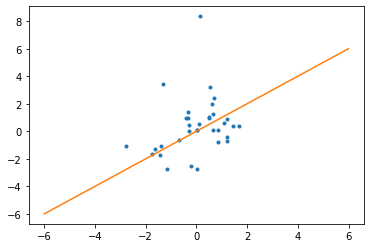

In [8]:
print(np.std(y))
print(np.std(y - y_val_preds_list, ddof=1))

plt.plot(y, y_val_preds_list, ".")
plt.plot([-6,6],[-6,6])


median_abs_deviation(y - y_val_preds_list)



In [133]:
from collections import Counter


flat_best_indexes_list= [item for sublist in best_indexes_list for item in sublist]

occurence_count = Counter(flat_best_indexes_list)
occurence_count

fig, ax = plt.subplots(1,1, figsize=(9, 3))
plt.hist(flat_best_indexes_list, bins=407-295)
plt.xlabel("index")
plt.ylabel("Frequency")

#residual_plot(rv_np, wls[0], ccf_list, "median", plot_title = "Normalized Mean Shifted CCFs")
#plt.vlines(wls[0][best_indexes], ymin=-0.0013, ymax=0.00125, color="k")

most_comm_5 = occurence_count.most_common(4)
print(most_comm_5)
most_comm_5_indexes = np.array(most_comm_5).transpose()[0]
print(most_comm_5_indexes)

residual_plot(rv_np, wls[0], ccf_list, "median", plot_title = "Normalized Mean Shifted CCFs")
plt.vlines(wls[0][most_comm_5_indexes], ymin=-0.0013, ymax=0.00125, color="k")


NameError: name 'best_indexes_list' is not defined

0.0 1.0


[350, 380, 398, 327, 333]

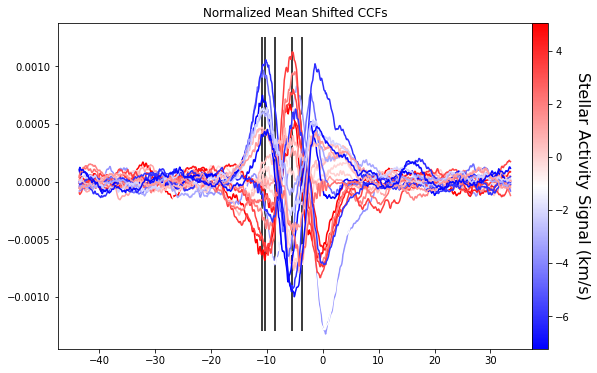

In [163]:
best_indexes =[350, 380, 398, 327, 333]#[335, 360, 375, 390, 430]#[350, 388, 398, 408, 441]#[345, 379, 391, 403, 413, 440] #[310 , 348, 358, 368, 401]#[345, 379, 391, 403, 413, 440] #
#best_indexes = np.array(best_indexes) +3 #+40#


residual_plot(rv_np, wls[0], ccf_list, "median", plot_title = "Normalized Mean Shifted CCFs")
plt.vlines(wls[0][best_indexes], ymin=-0.0013, ymax=0.00125, color="k")

best_indexes

In [7]:
# Run the weighted LS fit

ccf_indexes =  [352, 305, 325, 367, 406]
# HD 34411: [350, 388, 398, 408, 441]
# HD 10150: [330, 364, 376, 388, 398, 425]
# HD 26965: [301, 339, 349, 359, 392]
# HD 10700: [306, 347, 357, 367, 406]

a_coeff, y_preds, CCF_matrix, raw_rms, ccf_corr_rms = Weighted_LS_fit(ccf_indexes, ccf_list_np, 
                                                     ccf_list_np_transpose,rv_np, s_rv_np)



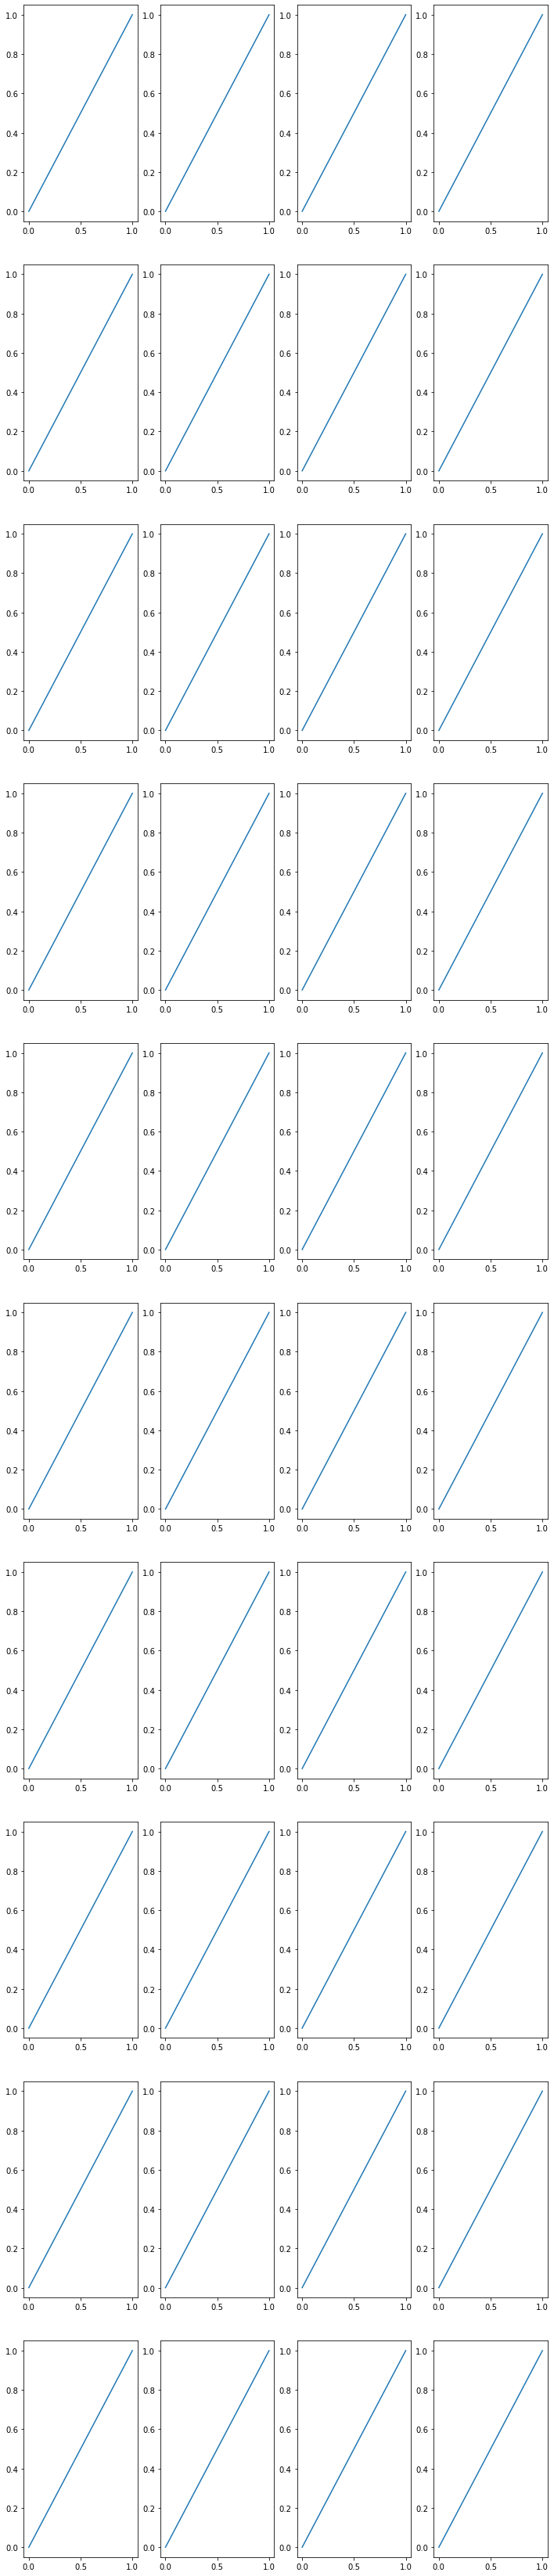

In [275]:
numcols = 4
numrows = numplot/numcols
fig, ax = plt.subplots(int(numrows), int(numcols), figsize=(12, 1.5*numplot))

for j in np.arange(0, numplot):
    #multi_residual_plot(rv_np, wls[0], ccf_list, "median", plot_title = "Normalized Mean Shifted CCFs", numplot=i)
    
    col = int(j/numrows)
    row = int(j % numrows)
    
    #print(str(col)+", "+str(row))
    
    ax[row][col].plot([0,1],[0,1])

-----------------
run: 0, indexes: [284 296 340 394]
raw rvs, rms scatter:2.905
CCF predictions, rms scatter: 2.805
-----------------
run: 1, indexes: [284 301 347 394]
raw rvs, rms scatter:2.905
CCF predictions, rms scatter: 2.694
-----------------
run: 2, indexes: [289 301 340 394]
raw rvs, rms scatter:2.905
CCF predictions, rms scatter: 2.888
-----------------
run: 3, indexes: [284 301 340 403]
raw rvs, rms scatter:2.905
CCF predictions, rms scatter: 2.777
-----------------
run: 4, indexes: [283 301 340 394]
raw rvs, rms scatter:2.905
CCF predictions, rms scatter: 2.712
-----------------
run: 5, indexes: [284 301 338 394]
raw rvs, rms scatter:2.905
CCF predictions, rms scatter: 2.706
-----------------
run: 6, indexes: [284 306 340 394]
raw rvs, rms scatter:2.905
CCF predictions, rms scatter: 2.927
-----------------
run: 7, indexes: [284 301 340 397]
raw rvs, rms scatter:2.905
CCF predictions, rms scatter: 2.724
-----------------
run: 8, indexes: [283 301 340 394]
raw rvs, rms scatte

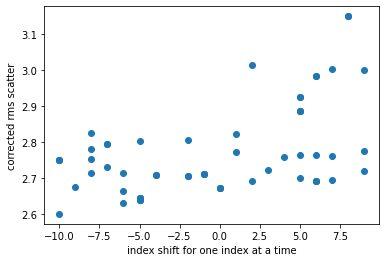

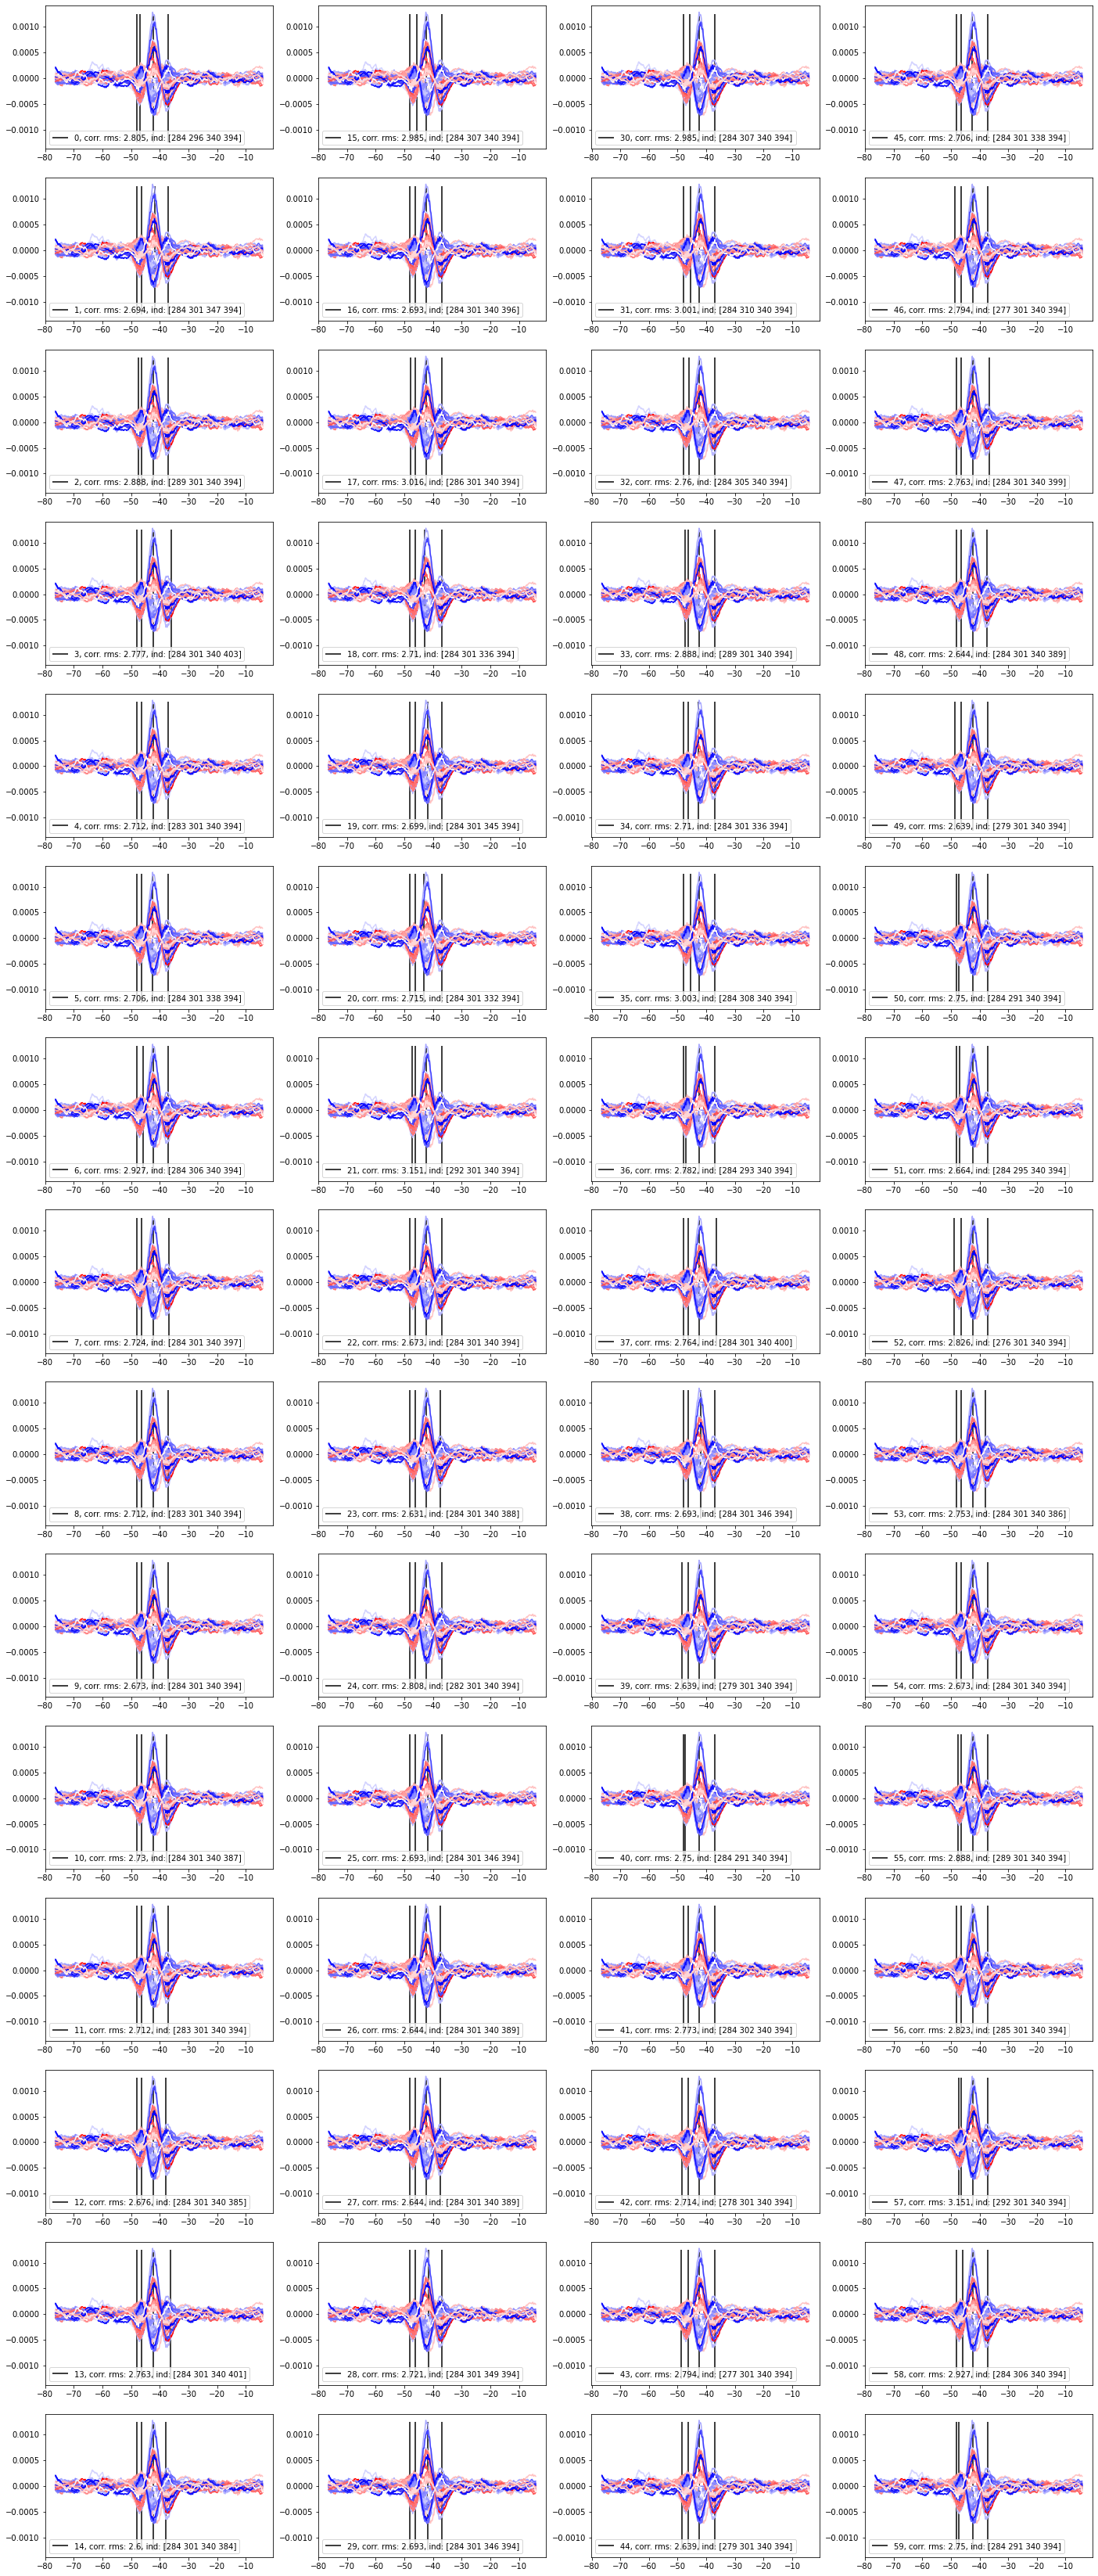

In [57]:
# Run the weighted crossval LS fit and replace one index at a time
#diff = 32
#start_ind = 325

ccf_indexes_list = []
delta_ind_list = []
ccf_corr_rms_list = []
numplot=60

for i in range(0, numplot):
    ccf_indexes = np.array([284, 284+sigma_og, 340, 394])#[337, 356, 370, 394])#[330, 380, 395, 430])#[345, 355, 365, 375]#[346, 332, 357, 367, 318]
    rand_index = np.random.randint(0, len(ccf_indexes))
    delta_ind = np.random.choice(np.arange(-10,10))
    delta_ind_list.append(delta_ind)
    ccf_indexes[rand_index] = ccf_indexes[rand_index]+delta_ind

    y_preds, raw_rms, ccf_corr_rms, new_train_rms_list, a_coeff_list = Weighted_LS_crossval_fit(ccf_indexes, ccf_list_np, rv_np, s_rv_np)
    y = rv_np
    
    ccf_indexes_list.append(ccf_indexes)
    ccf_corr_rms_list.append(ccf_corr_rms)

    #residual_plot(rv_np, wls[0], ccf_list, "median", plot_title = "HD"+star_name+", ind: "+str(ccf_indexes))
    #plt.vlines(wls[0][ccf_indexes], ymin=-0.0013, ymax=0.00125, color="k", label="corr. rms: "+str(round(ccf_corr_rms,3))+" m/s")
    #plt.legend()
    
    print("-----------------")
    print("run: "+str(i)+", indexes: "+str(ccf_indexes))
    print("raw rvs, rms scatter:"+str(round(raw_rms,3)))
    print("CCF predictions, rms scatter: "+str(round(ccf_corr_rms,3)))


plt.scatter(delta_ind_list, ccf_corr_rms_list)
plt.xlabel("index shift for one index at a time")
plt.ylabel("corrected rms scatter")


numcols = int(4)
numrows = numplot/numcols
fig, ax = plt.subplots(int(numrows), int(numcols), figsize=(24, numplot))
for j in np.arange(0, numplot):
    #multi_residual_plot(rv_np, wls[0], ccf_list, "median", plot_title = "Normalized Mean Shifted CCFs", numplot=i)
    
    #--- resid plot ----
    
    col = int(j/numrows)
    row = int(j % numrows)
    
    rv_list = rv_np
    x_axis = wls[0]
    ccfs_of_interest = ccf_list
    num_ref_ccf = "median"
    plot_title = "Normalized Mean Shifted CCFs"
    
    min_rv = np.min(rv_list)
    max_rv = np.max(rv_list)
    cscale_residuals = (np.array(rv_list - min_rv) / (max_rv - min_rv))
    print(np.min(cscale_residuals), np.max(cscale_residuals))

    color = plt.cm.jet([0.25, 0.75])
    n = len(ccfs_of_interest)
    colors = plt.cm.bwr(cscale_residuals)

    num = 0
    for i in np.arange(0, len(ccfs_of_interest)):
        if num_ref_ccf == "median":
            ax[row][col].plot(x_axis, ccfs_of_interest[i] - np.median(list(ccfs_of_interest), axis=0),
                       color=colors[num])
        else:
            if i != num_ref_ccf:
                ax[row][col].plot(x_axis, ccfs_of_interest[i] - ccfs_of_interest[num_ref_ccf], color=colors[num])
        num += 1
    
    
    
    #---- end of resid plot ----
    ax[row][col].vlines(wls[0][ccf_indexes_list[j]], ymin=-0.00125, ymax=0.00125, 
                 color="k", label=str(j)+", corr. rms: "+str(round(ccf_corr_rms_list[j],3))+", ind: "+str(ccf_indexes_list[j]))
    ax[row][col].legend(loc="lower left")

In [306]:
ccf_indexes_list[30]

array([337, 356, 370, 394])

raw rms: 3.74067983061374
0.0 1.0
0.0 1.0


array([ 0.74033304,  5.83581491, -2.94371085,  0.56819482,  0.81090494,
        1.80272623, -0.30060248,  1.24864145,  5.2364306 ,  4.15544076,
        2.69536539,  4.34903665, -3.82681326, -5.34649329, -6.46276907,
        3.13739343, -5.23348288,  1.37977167, -2.39677863, -1.41020255,
        2.09168954, -6.13089041])

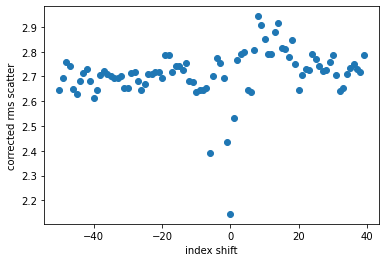

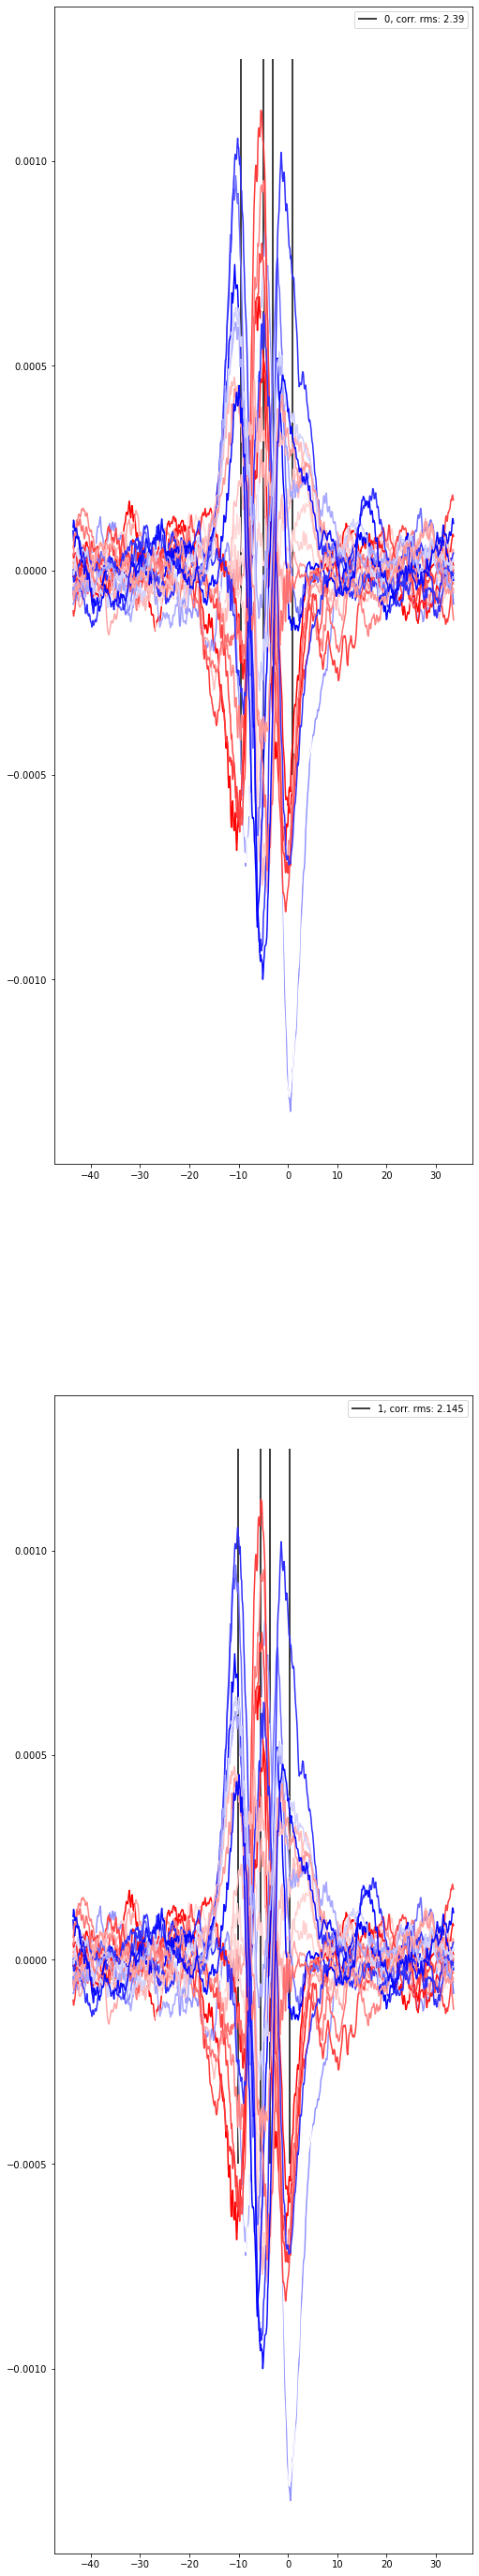

In [202]:
# Run the weighted crossval LS fit and shift the indexes
ccf_corr_rms_list = []
index_shift = np.arange(-50,40)
ccf_indexes_list = []
start_index = 361

for i in index_shift:
    #ccf_indexes = [start_index, start_index+sigma_og, 
    #               start_index+2*sigma_og, start_index+3*sigma_og]
    ccf_indexes = [335, 380, 400, 440]
    ccf_indexes = list(np.array(ccf_indexes) - i)
    ccf_indexes_list.append(ccf_indexes)

    y_preds, raw_rms, ccf_corr_rms, new_train_rms_list = Weighted_LS_crossval_fit(ccf_indexes, ccf_list_np, rv_np, s_rv_np)
    y = rv_np

    #print("raw rvs, rms scatter:"+str(round(raw_rms,3)))
    #print("CCF predictions, rms scatter: "+str(round(ccf_corr_rms,3)))
    ccf_corr_rms_list.append(ccf_corr_rms)

plt.scatter(index_shift, ccf_corr_rms_list)
plt.xlabel("index shift")
plt.ylabel("corrected rms scatter")

print("raw rms: "+str(raw_rms))
np.mean(ccf_corr_rms_list)


values_265 = list(np.where(np.array(ccf_corr_rms_list)-2.4<0.01)[0])
indexes_265 = np.array(ccf_indexes_list)[values_265]
ccf_corr_rms_265 = np.array(ccf_corr_rms_list)[values_265]

# Create the residual plot by looping through the list of CCFs ordered by date
numplot=len(indexes_265)
fig, ax = plt.subplots(numplot, 1, figsize=(8, 50))

#fig, ax = plt.subplots(15, 1, figsize=(10, 6))
for j in np.arange(0, len(indexes_265)):
    #multi_residual_plot(rv_np, wls[0], ccf_list, "median", plot_title = "Normalized Mean Shifted CCFs", numplot=i)
    
    #--- resid plot ----
    
    rv_list = rv_np
    x_axis = wls[0]
    ccfs_of_interest = ccf_list
    num_ref_ccf = "median"
    plot_title = "Normalized Mean Shifted CCFs"
    
    min_rv = np.min(rv_list)
    max_rv = np.max(rv_list)
    cscale_residuals = (np.array(rv_list - min_rv) / (max_rv - min_rv))
    print(np.min(cscale_residuals), np.max(cscale_residuals))

    col = plt.cm.jet([0.25, 0.75])
    n = len(ccfs_of_interest)
    colors = plt.cm.bwr(cscale_residuals)

    num = 0
    for i in np.arange(0, len(ccfs_of_interest)):
        if num_ref_ccf == "median":
            ax[j].plot(x_axis, ccfs_of_interest[i] - np.median(list(ccfs_of_interest), axis=0),
                       color=colors[num])
        else:
            if i != num_ref_ccf:
                ax[j].plot(x_axis, ccfs_of_interest[i] - ccfs_of_interest[num_ref_ccf], color=colors[num])
        num += 1
    
    
    
    #---- end of resid plot ----
    ax[j].vlines(wls[0][indexes_265[j]], ymin=-0.00050, ymax=0.00125, 
                 color="k", label=str(j)+", corr. rms: "+str(round(ccf_corr_rms_265[j],3)))
    ax[j].legend()

rv_np

In [136]:
indexes_265[9]

array([337, 356, 375, 394])

In [121]:
indexes_265[10]

array([379, 398, 417, 436])

In [109]:
indexes_265[13]



array([361, 376, 391, 406])

3.74067983061374
2.329858813346781
0.0 1.0


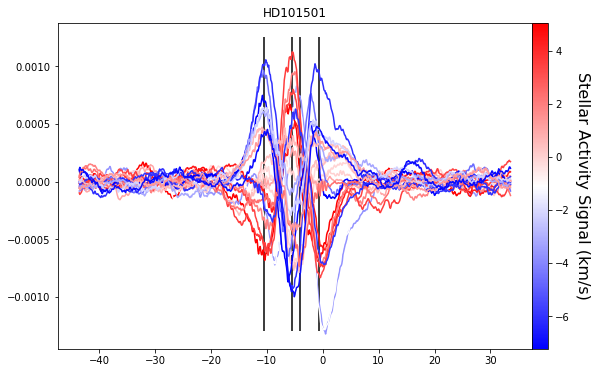

In [288]:
start_index = 361
#ccf_indexes = [start_index, start_index+sigma_og,
#               start_index+2*sigma_og, start_index+3*sigma_og]
ccf_indexes = np.array([330, 380, 395, 429])

y_preds, raw_rms, ccf_corr_rms, new_train_rms_list = Weighted_LS_crossval_fit(ccf_indexes, ccf_list_np, rv_np, s_rv_np)

print(raw_rms)
print(ccf_corr_rms)

residual_plot(rv_np, wls[0], ccf_list, "median", plot_title = "HD"+star_name)
plt.vlines(wls[0][ccf_indexes], ymin=-0.0013, ymax=0.00125, color="k")


In [63]:
indexes_85[10]

array([328, 345, 362, 379])

0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0


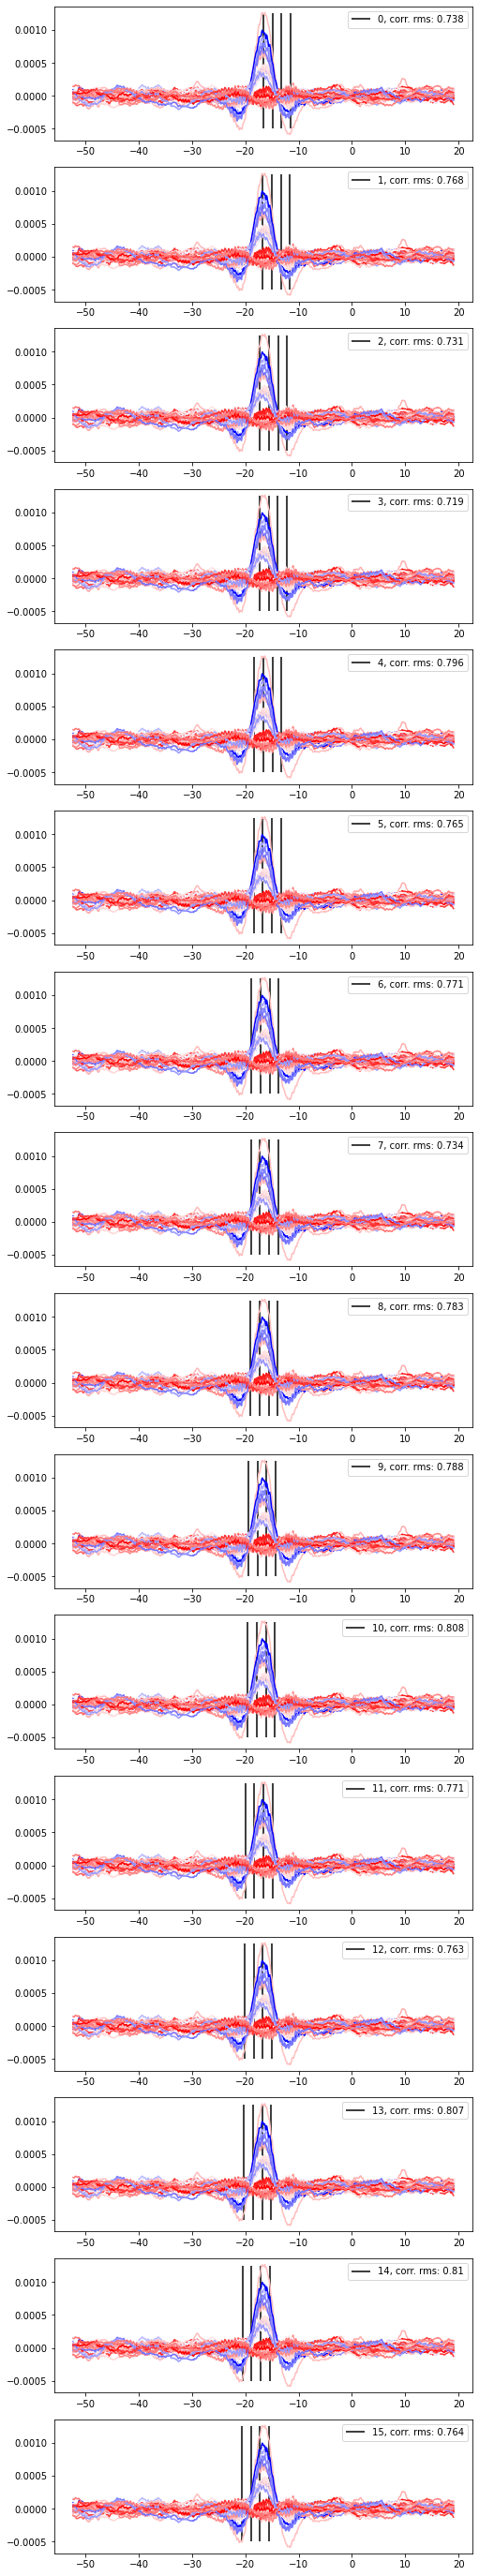

In [62]:
values_85 = list(np.where(np.array(ccf_corr_rms_list)-0.80<0.01)[0])
indexes_85 = np.array(ccf_indexes_list)[values_85]
ccf_corr_rms_85 = np.array(ccf_corr_rms_list)[values_85]


# Create the residual plot by looping through the list of CCFs ordered by date
numplot=len(indexes_85)
fig, ax = plt.subplots(numplot, 1, figsize=(8, 50))

#fig, ax = plt.subplots(15, 1, figsize=(10, 6))
for j in np.arange(0, len(indexes_85)):
    #multi_residual_plot(rv_np, wls[0], ccf_list, "median", plot_title = "Normalized Mean Shifted CCFs", numplot=i)
    
    #--- resid plot ----
    
    rv_list = rv_np
    x_axis = wls[0]
    ccfs_of_interest = ccf_list
    num_ref_ccf = "median"
    plot_title = "Normalized Mean Shifted CCFs"
    
    min_rv = np.min(rv_list)
    max_rv = np.max(rv_list)
    cscale_residuals = (np.array(rv_list - min_rv) / (max_rv - min_rv))
    print(np.min(cscale_residuals), np.max(cscale_residuals))

    col = plt.cm.jet([0.25, 0.75])
    n = len(ccfs_of_interest)
    colors = plt.cm.bwr(cscale_residuals)

    num = 0
    for i in np.arange(0, len(ccfs_of_interest)):
        if num_ref_ccf == "median":
            ax[j].plot(x_axis, ccfs_of_interest[i] - np.median(list(ccfs_of_interest), axis=0),
                       color=colors[num])
        else:
            if i != num_ref_ccf:
                ax[j].plot(x_axis, ccfs_of_interest[i] - ccfs_of_interest[num_ref_ccf], color=colors[num])
        num += 1
    
    
    
    #---- end of resid plot ----
    ax[j].vlines(wls[0][indexes_85[j]], ymin=-0.00050, ymax=0.00125, 
                 color="k", label=str(j)+", corr. rms: "+str(round(ccf_corr_rms_85[j],3)))
    ax[j].legend()



0.0 1.0


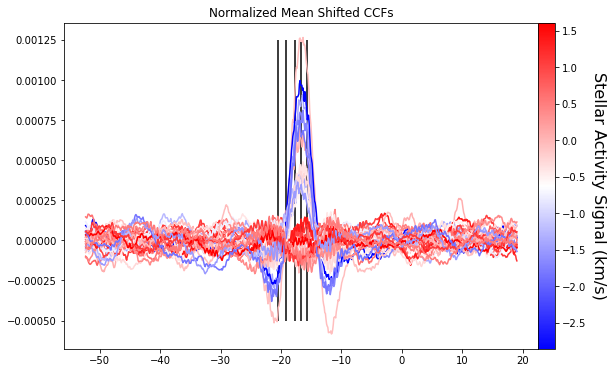

In [13]:
residual_plot(rv_np, wls[0], ccf_list, "median", plot_title = "Normalized Mean Shifted CCFs")
plt.vlines(wls[0][ccf_indexes], ymin=-0.00050, ymax=0.00125, color="k")




2.329858813346781

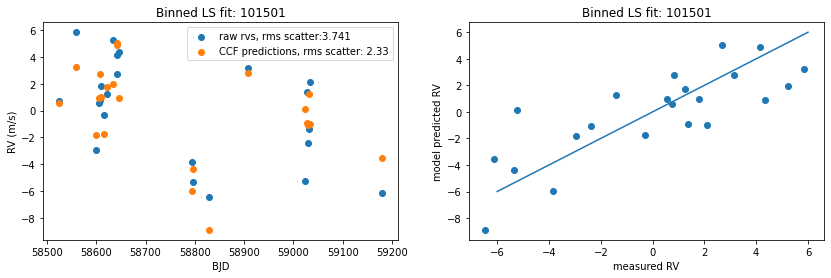

In [289]:
fig, ax = plt.subplots(1,2, figsize=(14, 4))
ax[0].scatter(time_np+np.min(df_sorted["BJD"]),
              y, label="raw rvs, rms scatter:"+str(round(raw_rms,3)))
ax[0].scatter(time_np+np.min(df_sorted["BJD"]),
              y_preds, label="CCF predictions, rms scatter: "+str(round(ccf_corr_rms,3)))
ax[0].set_ylabel("RV (m/s)")
ax[0].set_xlabel("BJD")
ax[0].set_title("Binned LS fit: "+star_name)
ax[0].legend()

ax[1].scatter(y, y_preds)
ax[1].plot([-6,6],[-6,6])
ax[1].set_xlabel("measured RV")
ax[1].set_ylabel("model predicted RV")
ax[1].set_title("Binned LS fit: "+star_name)


np.std(y-y_preds,ddof=1)

In [291]:
# create pandas dataframe to write coeff solution to csv
df_coeff = pd.DataFrame(list(zip([ccf_indexes], [a_coeff], [star_name], [raw_rms], [ccf_corr_rms])),
                        columns=["ccf_indexes","a_coeff", "star name", "raw_rms", "ccf_corr_rms"])

# Make directory if it does not exist
if not os.path.exists('HD'+star_name+'/'+'binned_coeffs'):
    os.makedirs('HD'+star_name+'/'+'binned_coeffs')

# write results to a file 
#df_coeff.to_csv('HD'+star_name+'/'+'binned_coeffs/coeff'+star_name+"_"+file_end+'.csv', index=False)

In [52]:
jitterpar = 0

In [13]:
def log_likelihood(theta, t, x, y, e):
    #amplitude, jitterpar, D, a0, a1, a2, a3, a4, a5, a6, a7 = theta
    D, a0, a1, a2, a3, a4  = theta
    #jitterpar, D, a0, a1, a2, a3, a4 = theta
    #model = amplitude * np.sin(2*np.pi*(t-T_c)/period + np.pi) + D + a0*x[:,0] + a1*x[:,1] + a2*x[:,2] + a3*x[:,3] + a4*x[:,4] +a5*x[:,5] + a6*x[:,6] + a7*x[:,7] #+ a8*x[:,8]+ a9*x[:,9] + a10*x[:,10] + a11*x[:,11] +a12*x[:,12]
    model = D + a0*x[:,0] + a1*x[:,1] + a2*x[:,2] + a3*x[:,3] + a4*x[:,4]# +a5*x[:,5] + a6*x[:,6] + a7*x[:,7] +a8*x[:,8]
    sigma2 = e**2 + jitterpar**2
    loglikelihood =  -0.5 * np.sum((y - model) ** 2 / sigma2 )#+ np.log(sigma2))
    return loglikelihood

In [14]:
#solnx = np.array([2.20048546e+00])#np.array([0.01e+00,  2.20048546e+00, -7.21531857e-09])
#solnx = np.append(solnx, a_coeff[0])
#solnx = np.append(solnx, a_coeff[1])
#solnx = np.append(solnx, a_coeff[2])
solnx = a_coeff

#num = 0
#for i in np.arange(0, len(a_coeff[0:])): # change back to 4 if you include linear and quadratic
#    solnx = np.append(solnx, a_coeff[1:][i])
#    num +=1



In [15]:
solnx

array([ 0.37453246, -2.5854755 ,  0.76284255, -0.10340277,  1.54395907,
       -1.06380613])

In [16]:
len(solnx)

6

In [17]:
def log_prior(theta):
    D ,  a0, a1, a2, a3, a4 = theta
    #jitterpar, D , a0, a1, a2, a3, a4 = theta
    #amplitude, jitterpar, D, a0, a1, a2, a3, a4, a5, a6, a7, a8, a9, a10 = theta
    #if 0.01 < jitterpar < 4.0:
    #    return 0.0
    if 0.1 < D < 5:
        return 0.0
    return -np.inf

In [18]:
def log_probability(theta, t, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, t, x, y, yerr)

In [19]:
#yerr_same = np.array([0.000222]*len(yerr))
#yerr_same

array([0.000222, 0.000222, 0.000222, 0.000222, 0.000222, 0.000222,
       0.000222, 0.000222, 0.000222, 0.000222, 0.000222, 0.000222,
       0.000222, 0.000222, 0.000222, 0.000222, 0.000222, 0.000222,
       0.000222, 0.000222, 0.000222, 0.000222, 0.000222, 0.000222,
       0.000222, 0.000222, 0.000222, 0.000222, 0.000222, 0.000222,
       0.000222, 0.000222, 0.000222, 0.000222])

In [20]:
pos = solnx + 1e-4 * np.random.randn(60, len(solnx)) #ball size array for each parameter
#pos[:,3] = pos[:,3]*2.6897657941202826e+14
#pos[:,13] = pos[:,13]*2.6897657941202826e+14
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(time_np, CCF_matrix, y, yerr))
sampler.run_mcmc(pos, 5000, progress=True)

100%|██████████| 5000/5000 [02:26<00:00, 34.02it/s]


State([[ 0.3745719  -2.58551352  0.76280461 -0.10342422  1.54403265 -1.06373592]
 [ 0.37447126 -2.58508164  0.7628754  -0.10333652  1.54368117 -1.0638074 ]
 [ 0.37444797 -2.58532548  0.76277616 -0.10334664  1.54396068 -1.06362397]
 [ 0.37448227 -2.58537567  0.76274409 -0.10340651  1.54384385 -1.06370633]
 [ 0.37454146 -2.58591196  0.76281932 -0.10343767  1.54433305 -1.06380701]
 [ 0.37452819 -2.58531326  0.76307595 -0.10341151  1.54385727 -1.06397483]
 [ 0.37446951 -2.58533118  0.76272827 -0.10332121  1.54385504 -1.06373051]
 [ 0.37459107 -2.58537728  0.76287103 -0.10342107  1.54379664 -1.06385128]
 [ 0.37452904 -2.58582558  0.76283856 -0.10348205  1.54435825 -1.06369609]
 [ 0.37455042 -2.58535752  0.76285798 -0.10344562  1.54387095 -1.06374306]
 [ 0.37454256 -2.58544142  0.76284245 -0.10346979  1.54394866 -1.0637155 ]
 [ 0.37453709 -2.5858747   0.76279323 -0.10336338  1.54442778 -1.06370796]
 [ 0.37448362 -2.58553754  0.76277235 -0.10335369  1.54386725 -1.06395507]
 [ 0.3744746  -2.58

Text(0.5, 0, 'step number')

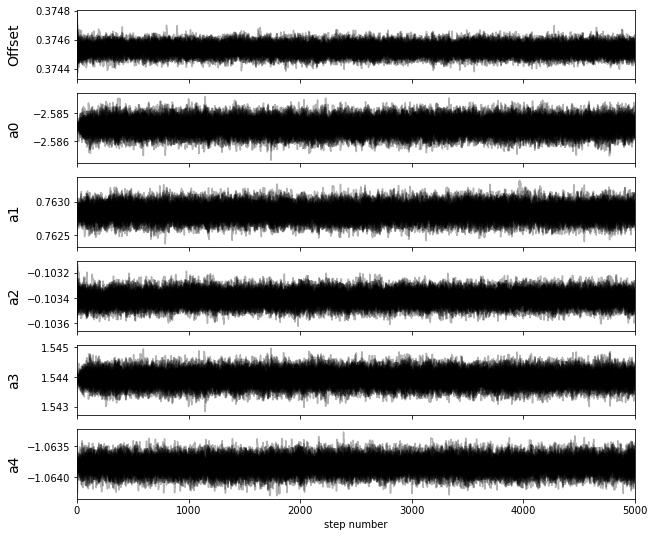

In [21]:
fig, axes = plt.subplots(len(solnx), figsize=(10, 1.5*len(solnx)), sharex=True)
samples = sampler.get_chain()
labels = ["Offset","a0", "a1", "a2", "a3",
          "a4"]#, "a5", "a6", "a7", "a8"]
#["Jitterpar","Offset","a0", "a1", "a2", "a3",
#         "a4", "a5", "a6", "a7", "a8"]
#labels = ["Amplitude", "Jitterpar","Offset", "a0", "a1", "a2", "a3",
#          "a4", "a5", "a6", "a7", "a8", "a9", "a10", "a11", "a12"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i], size=14)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [23]:
# discard first 100 burn-in samples
flat_samples = sampler.get_chain(discard=2000, thin=15, flat=True)



In [24]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

print("Chi-Sq coeffs: "+str(a_coeff))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Chi-Sq coeffs: [ 0.37453246 -2.5854755   0.76284255 -0.10340277  1.54395907 -1.06380613]


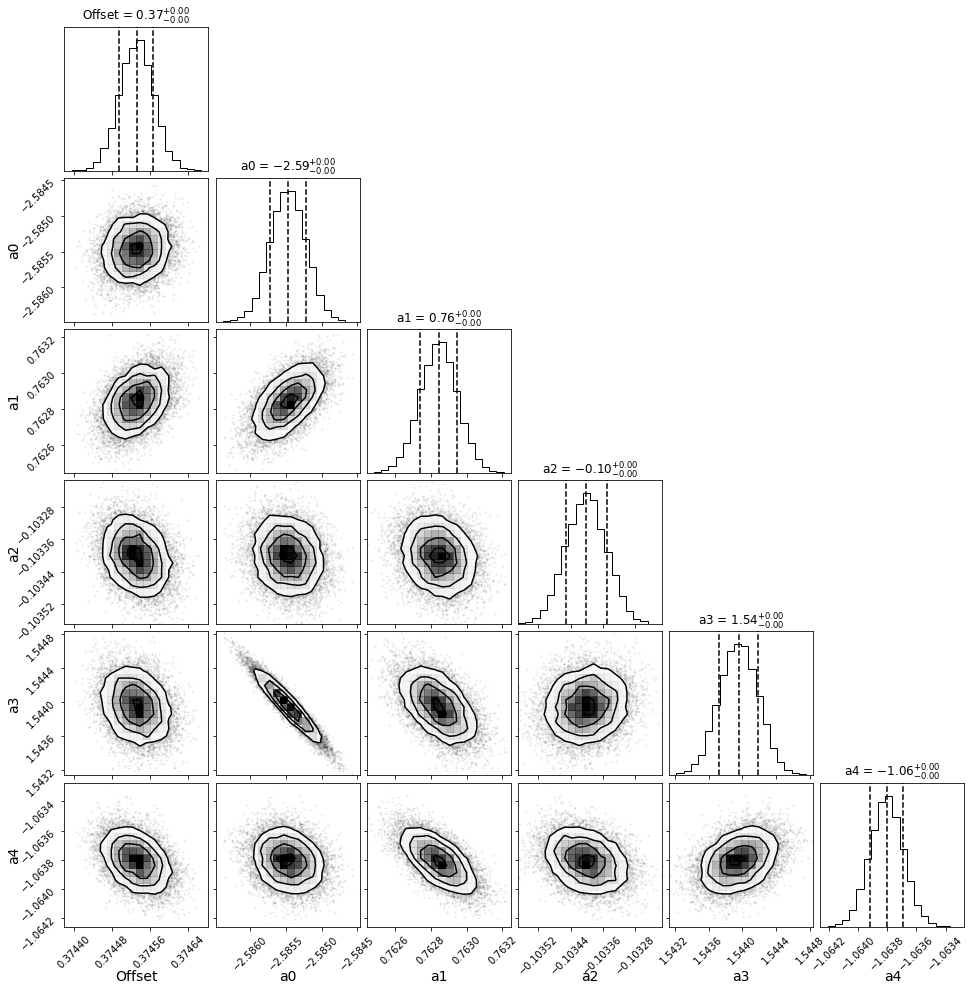

In [25]:
import corner
fig = corner.corner(
    flat_samples,
    labels=labels,
    quantiles=[0.159, 0.5, 0.841],
    show_titles=True,
    label_kwargs=dict(fontsize=14))

a_coeff: [ 0.37453246 -2.5854755   0.76284255 -0.10340277  1.54395907 -1.06380613]
A_mcmc_coeffs: [ 0.37453207 -2.58546934  0.76284399 -0.10340196  1.54395706 -1.06380532]


Text(0.5, 1.0, 'Binned mcmc fit: 10700')

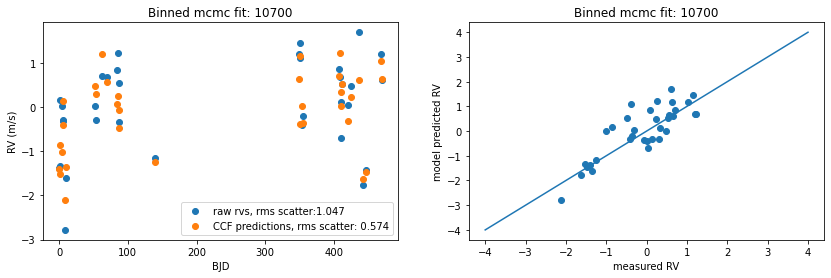

In [26]:
D_mcmc = np.percentile(flat_samples[:, 0], [50])[0]

All_mcmc_coeffs = np.zeros(len(a_coeff))
for i in np.arange(0, len(a_coeff)):
    All_mcmc_coeffs[i]=  np.percentile(flat_samples[:, i], [50])[0]

print('a_coeff: '+str(a_coeff))
print('A_mcmc_coeffs: '+str(All_mcmc_coeffs))
y_preds = D_mcmc + CCF_matrix.dot(All_mcmc_coeffs[1:])#(A_mcmc_coeffs)

fig, ax = plt.subplots(1,2, figsize=(14, 4))
ax[0].scatter(time_np, y, label="raw rvs, rms scatter:"+str(round(np.std(y, ddof=1),3)))
ax[0].scatter(time_np, y_preds, label="CCF predictions, rms scatter: "+str(round(np.std(y-y_preds,ddof=1),3)))
ax[0].set_ylabel("RV (m/s)")
ax[0].set_xlabel("BJD")
ax[0].set_title("Binned mcmc fit: "+star_name)
ax[0].legend()


ax[1].scatter(y_preds, y)
ax[1].plot([-4,4],[-4,4])
ax[1].set_xlabel("measured RV")
ax[1].set_ylabel("model predicted RV")
ax[1].set_title("Binned mcmc fit: "+star_name)

In [154]:
# compute log-likelhoods

# mcmc fit
mcmc_log_likelihood = log_likelihood(All_mcmc_coeffs
                                     ,time_np, CCF_matrix, y, yerr)
print("mcmc_log_likelihood: "+str(mcmc_log_likelihood))


LS_log_likelihood = log_likelihood(a_coeff,time_np, CCF_matrix, y, yerr)
print("LS_log_likelihood: "+str(LS_log_likelihood))

mcmc_log_likelihood: -208807554.67509225
LS_log_likelihood: -208807554.67082506


In [700]:
# mcmc cross-validation



0.5597366551443247

In [338]:
np.std(y, ddof=1)

1.9953064054798533